# Portfolio Inception
For Rutger's [Fintech Bootcamp]():
> You have been investing in algorithmic trading strategies. Some of the investment managers love them, some hate them, but they all think their way is best.

> You just learned these quantitative analysis techniques with Python and Pandas, and you want to determine which portfolio is performing the best across multiple areas: volatility, returns, risk, and Sharpe ratios.

> ...create a tool (an analysis notebook) that analyzes and visualizes the major metrics of the portfolios across all of these areas, and determine which portfolio outperformed the others. You will be given the historical daily returns of several portfolios: some from the firm's algorithmic portfolios, some that represent the portfolios of famous "whale" investors like Warren Buffett, and some from the big hedge and mutual funds. You will then use this analysis to create a custom portfolio of stocks and compare its performance to that of the other portfolios, as well as the larger market ([S&P 500 Index](https://en.wikipedia.org/wiki/S%26P/TSX_60)).

In [3]:
import pathlib as path
import datetime as dt
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# The three csvs we are working with all share the same name for the column of
# dates that we seek to convert to a DateTimeIndex
date_col = ["Date"]


whale_returns_path = r"resources\whale_returns.csv"
whale_returns_data_frame = pd.read_csv(whale_returns_path, 
                                       index_col = "Date", 
                                       parse_dates = date_col)


# We use raw strings to avoid escaped characters being read, as we ran into an
# error with '\a' in next line
algo_returns_path  = r"resources\algo_returns.csv"
algo_returns_data_frame = pd.read_csv(algo_returns_path, 
                                      index_col = "Date", 
                                      parse_dates = date_col)


sp500_history_path = r"resources\sp500_history.csv"
sp500_history_data_frame = pd.read_csv(sp500_history_path, 
                                       index_col = "Date", 
                                       parse_dates = date_col)

In [5]:
whale_returns_data_frame.head()

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC
Date,,,,
2015-03-02,NaN,NaN,NaN,NaN
2015-03-03,-0.001266,-0.004981,-0.000496,-0.006569
2015-03-04,0.002230,0.003241,-0.002534,0.004213
2015-03-05,0.004016,0.004076,0.002355,0.006726
2015-03-06,-0.007905,-0.003574,-0.008481,-0.013098


In [6]:
algo_returns_data_frame.head()

,Algo 1,Algo 2
Date,,
2014-05-28,0.001745,NaN
2014-05-29,0.003978,NaN
2014-05-30,0.004464,NaN
2014-06-02,0.005692,NaN
2014-06-03,0.005292,NaN


In [7]:
sp500_history_data_frame.head()

,Close
Date,
2019-04-23,$2933.68
2019-04-22,$2907.97
2019-04-18,$2905.03
2019-04-17,$2900.45
2019-04-16,$2907.06


In [8]:
print(whale_returns_data_frame.isnull().mean() * 100)

SOROS FUND MANAGEMENT LLC      0.09434
PAULSON & CO.INC.              0.09434
TIGER GLOBAL MANAGEMENT LLC    0.09434
BERKSHIRE HATHAWAY INC         0.09434
dtype: float64


In [9]:
whale_returns_data_frame.dropna(inplace = True)
print(whale_returns_data_frame.isnull().mean() * 100)

SOROS FUND MANAGEMENT LLC      0.0
PAULSON & CO.INC.              0.0
TIGER GLOBAL MANAGEMENT LLC    0.0
BERKSHIRE HATHAWAY INC         0.0
dtype: float64


In [10]:
print(algo_returns_data_frame.isnull().mean() * 100)

Algo 1    0.000000
Algo 2    0.483481
dtype: float64


In [11]:
whale_returns_data_frame.dropna(inplace = True)
print(whale_returns_data_frame.isnull().mean() * 100)

SOROS FUND MANAGEMENT LLC      0.0
PAULSON & CO.INC.              0.0
TIGER GLOBAL MANAGEMENT LLC    0.0
BERKSHIRE HATHAWAY INC         0.0
dtype: float64


In [12]:
print(sp500_history_data_frame.isnull().mean() * 100)

Close    0.0
dtype: float64


Given that the above cell's caluclations result in a mean of `0.0` we can assume that the `sp500_history.csv` file contains no null values. 

TODO: expound on further: why this makes sense given the type of dataset it is, plus an explaination of a visual glance

In [13]:
# use numpy to determine if all values are numberic
whale_returns_data_frame[~whale_returns_data_frame.applymap(np.isreal).all(1)]
# https://stackoverflow.com/questions/21771133/finding-non-numeric-rows-in-dataframe-in-pandas

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC
Date,,,,


In [14]:
algo_returns_data_frame[~algo_returns_data_frame.applymap(np.isreal).all(1)]

,Algo 1,Algo 2
Date,,


In [15]:
sp500_history_data_frame[~sp500_history_data_frame.applymap(np.isreal).all(1)]

,Close
Date,
2019-04-23,$2933.68
2019-04-22,$2907.97
2019-04-18,$2905.03
2019-04-17,$2900.45
2019-04-16,$2907.06
...,...
2012-10-05,$1460.93
2012-10-04,$1461.40
2012-10-03,$1450.99


In [16]:
sp500_history_data_frame["Close"] = sp500_history_data_frame["Close"].replace('[$]', '', regex = True).astype(float)
# https://stackoverflow.com/questions/32464280/how-to-convert-currency-column-with-and-to-numbers

In [17]:
sp500_history_data_frame.head()

,Close
Date,
2019-04-23,2933.68
2019-04-22,2907.97
2019-04-18,2905.03
2019-04-17,2900.45
2019-04-16,2907.06


In [18]:
# Daily Returns, dollar value converted to percentage 
# https://www.google.com/search?q=percentage+based+daily+return+formula&sca_esv=573710622&sxsrf=AM9HkKmkzrL9gdO9BJpegf3FLnmUQ-PWxQ%3A1697437632936&ei=wNcsZevZOLaw5NoPtqCc6Ak&oq=percentage+based+daily+return+fo&gs_lp=Egxnd3Mtd2l6LXNlcnAiIHBlcmNlbnRhZ2UgYmFzZWQgZGFpbHkgcmV0dXJuIGZvKgIIADIFECEYoAEyBRAhGKABSKUWUIIIWIgMcAB4ApABAJgBbKABnAKqAQMyLjG4AQPIAQD4AQHCAgQQABhHwgIFECEYqwLCAggQIRgWGB4YHeIDBBgAIEGIBgGQBgg&sclient=gws-wiz-serp&bshm=rimc/1
sp500_returns_data_frame = ((sp500_history_data_frame - sp500_history_data_frame.shift(-1)) / sp500_history_data_frame) * 100
sp500_returns_data_frame

,Close
Date,
2019-04-23,0.876374
2019-04-22,0.101101
2019-04-18,0.157658
2019-04-17,-0.227896
2019-04-16,0.050911
...,...
2012-10-05,-0.032171
2012-10-04,0.712331
2012-10-03,0.361133


In [19]:
# merge onlya ccepts totwtokwef weotikjneawotmesfnasdojthjnae tkroepgopi4aewn 
base_portfolio = pd.merge(whale_returns_data_frame, algo_returns_data_frame, left_index = True, right_index = True)
base_portfolio = pd.merge(base_portfolio, sp500_returns_data_frame, left_index = True, right_index = True)

base_portfolio = base_portfolio.rename(columns={"Close": "S&P TSX"})

base_portfolio.sample(15)

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,S&P TSX
Date,,,,,,,
2018-07-27,-0.008905,0.000373,-0.006623,-0.014417,-0.005066,-0.011983,-0.660560
2018-08-08,0.002018,0.005967,-0.010246,-0.004221,0.008429,-0.001812,-0.026245
2018-02-06,0.001447,0.007533,0.007571,0.017441,0.007653,0.009903,1.714197
2017-03-23,0.006461,0.002517,-0.000713,0.005890,0.001804,0.005120,-0.106140
2019-01-18,0.004605,0.005346,0.009285,0.013974,-0.004570,0.010387,1.301152
2017-01-13,0.005476,-0.001607,-0.002910,0.006231,-0.000065,0.006478,0.184645
2015-04-30,-0.009175,-0.004280,-0.010341,-0.007964,-0.009083,-0.009501,-1.023251
2017-01-24,0.005530,0.000632,-0.000058,0.009975,-0.001950,0.007471,0.652173
2018-04-27,-0.032711,0.000142,0.001663,-0.005245,-0.002001,-0.000782,0.111240


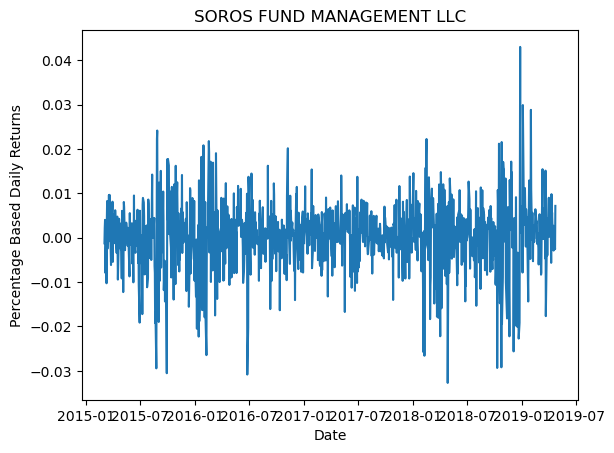

In [26]:
current_portfolio = r"SOROS FUND MANAGEMENT LLC"

plt.plot(base_portfolio[current_portfolio])

plt.title(current_portfolio)
plt.xlabel("Date")
plt.ylabel("Percentage Based Daily Returns")

plt.show()

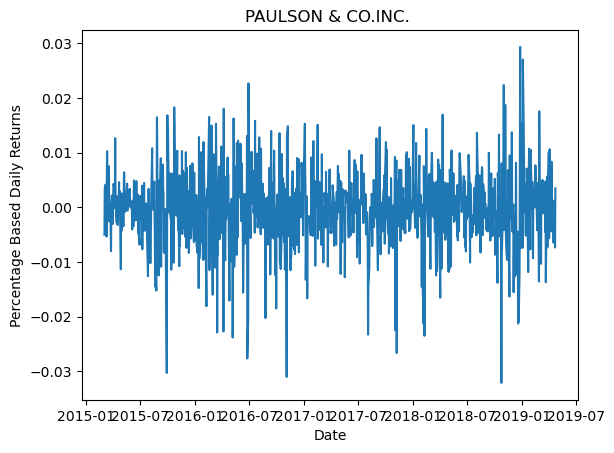

In [40]:
current_portfolio = r"PAULSON & CO.INC. "

plt.plot(base_portfolio[current_portfolio])

plt.title(current_portfolio)
plt.xlabel("Date")
plt.ylabel("Percentage Based Daily Returns")

plt.show()

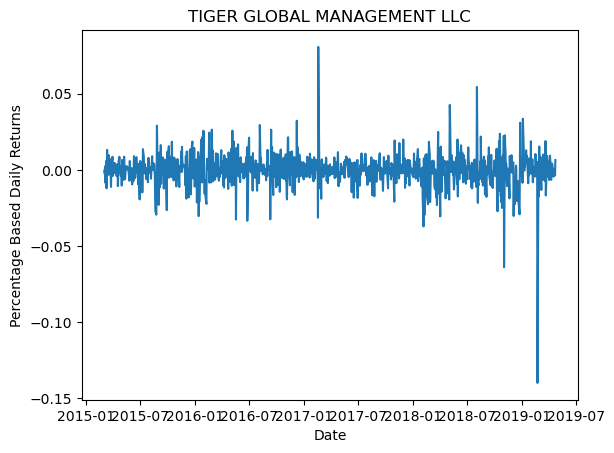

In [29]:
current_portfolio = "TIGER GLOBAL MANAGEMENT LLC"

plt.plot(base_portfolio[current_portfolio])

plt.title(current_portfolio)
plt.xlabel("Date")
plt.ylabel("Percentage Based Daily Returns")

plt.show()

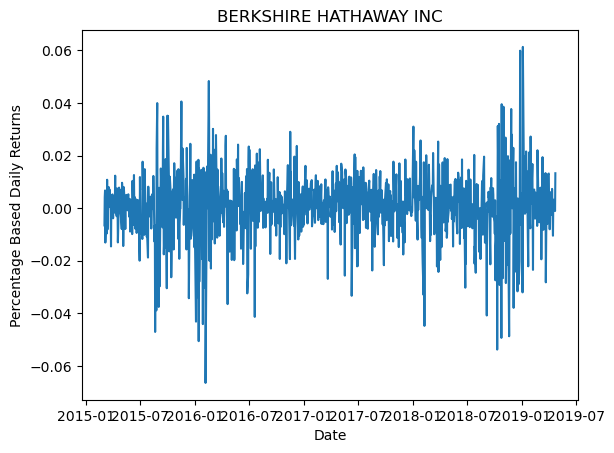

In [30]:
current_portfolio = "BERKSHIRE HATHAWAY INC"

plt.plot(base_portfolio[current_portfolio])

plt.title(current_portfolio)
plt.xlabel("Date")
plt.ylabel("Percentage Based Daily Returns")

plt.show()

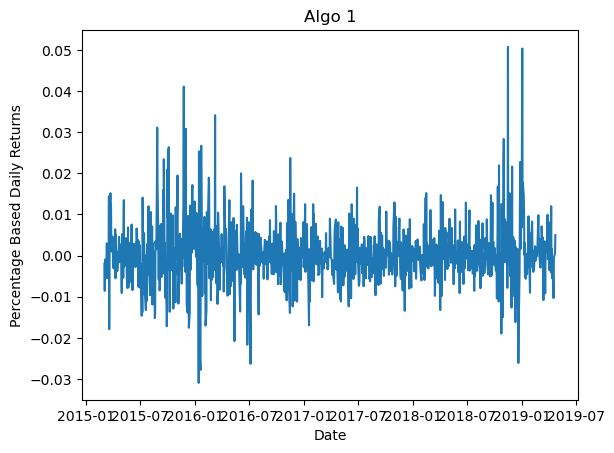

In [31]:
current_portfolio = "Algo 1"

plt.plot(base_portfolio[current_portfolio])

plt.title(current_portfolio)
plt.xlabel("Date")
plt.ylabel("Percentage Based Daily Returns")

plt.show()

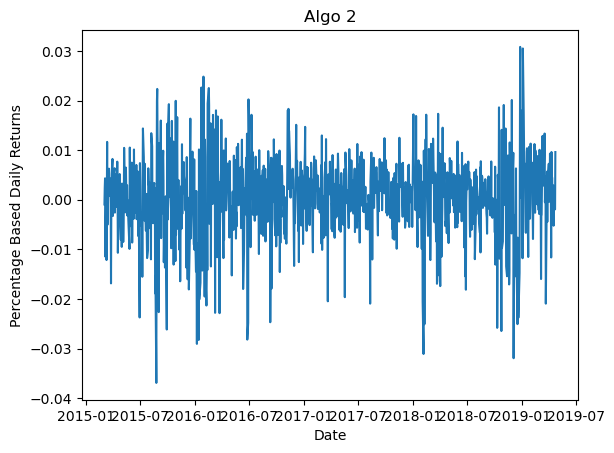

In [32]:
current_portfolio = "Algo 2"

plt.plot(base_portfolio[current_portfolio])

plt.title(current_portfolio)
plt.xlabel("Date")
plt.ylabel("Percentage Based Daily Returns")

plt.show()

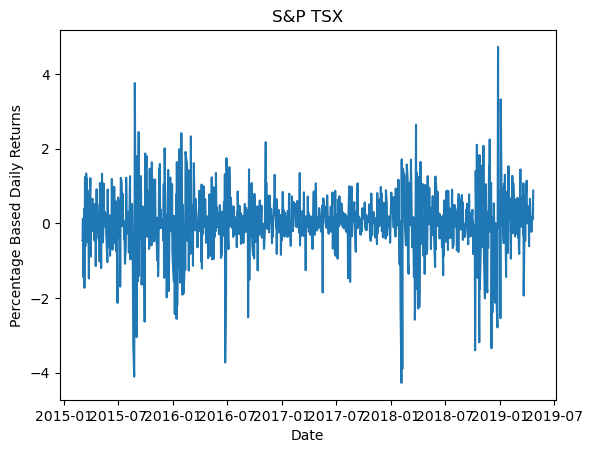

In [23]:
current_portfolio = "S&P TSX"

plt.plot(base_portfolio[current_portfolio])

plt.title(current_portfolio)
plt.xlabel("Date")
plt.ylabel("Percentage Based Daily Returns")

plt.show()

<Axes: xlabel='Date'>

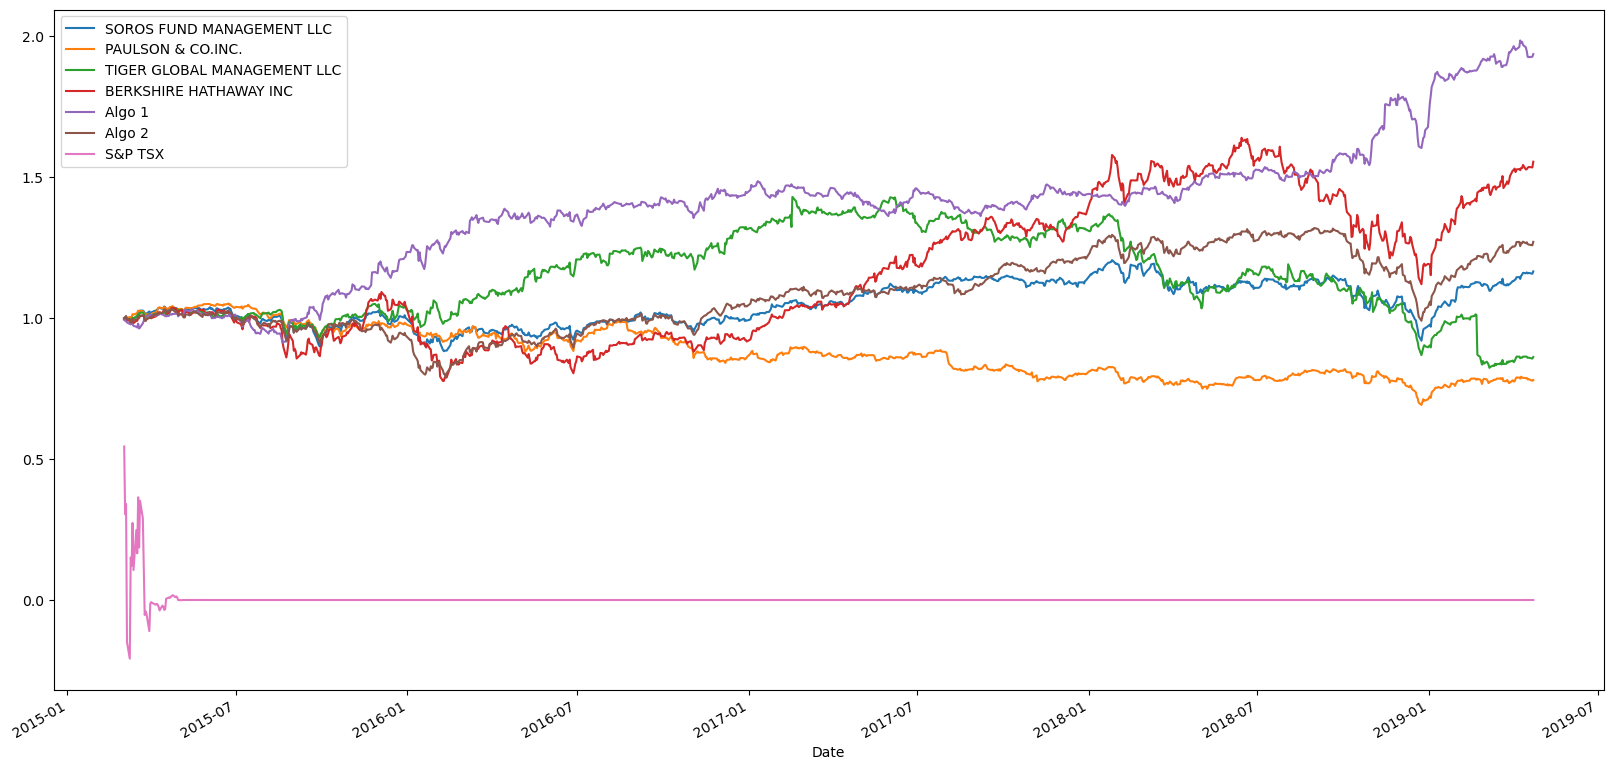

In [48]:
cum_portfolio = (1 + base_portfolio).cumprod()
cum_portfolio.plot(figsize = (20, 10))

<Axes: >

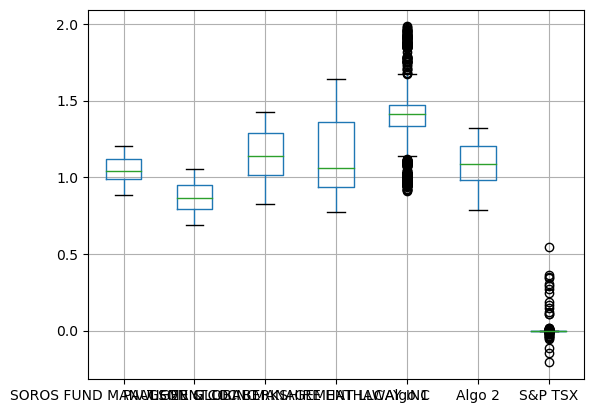

In [49]:
cum_portfolio.boxplot()

In [51]:
cum_portfolio.std()

SOROS FUND MANAGEMENT LLC      0.073238
PAULSON & CO.INC.              0.088455
TIGER GLOBAL MANAGEMENT LLC    0.149844
BERKSHIRE HATHAWAY INC         0.241575
Algo 1                         0.232277
Algo 2                         0.131700
S&P TSX                        0.033774
dtype: float64